# Importing Census Data

From inspection of te files, using a spliced version of GEOID will be able to match the STCOU column in the census data. We first read in our patent data and create our column to match STCOU.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import folium 
import matplotlib
import matplotlib.pyplot as plt
import warnings
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve, train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
df_patents = pd.read_csv("../patent_tract_state.csv")
df_patents = df_patents.loc[:, ~df_patents.columns.str.contains('^Unnamed')] #remove unamed indexes

#create the STCOU
df_patents['State ID'] = df_patents['State ID'].astype(str).str.zfill(2)  #string and leading 0 for state
df_patents['COUNTYFP'] = df_patents['COUNTYFP'].astype(int).astype(str).str.zfill(3) #string and leading 0 for county
df_patents['STCOU'] = df_patents["State ID"].map(str) + df_patents["COUNTYFP"]   #concat


df_patents.head()

,patent_id,date,title,section_id,inventor_id,city,state,it_cited,cited_by,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,State ID,State Name,STCOU
0,9682516,2017-06-20,Resin infusion of composite parts using a perf...,B,8628717-3,Melborne,AL,46,0,1.0,075,30200.0,1.075030e+09,302.0,Census Tract 302,01,Alabama,01075
1,9682514,2017-06-20,Method of manufacturing resin infused composit...,B,8628717-3,Melborne,AL,48,0,1.0,075,30200.0,1.075030e+09,302.0,Census Tract 302,01,Alabama,01075
2,8940213,2015-01-27,Resin infusion of composite parts using a perf...,B,8628717-3,Melborne,AL,42,3,1.0,075,30200.0,1.075030e+09,302.0,Census Tract 302,01,Alabama,01075
3,8438679,2013-05-14,Bedding system and the like having orientation...,A,6799341-1,Cullman,AL,14,3,1.0,043,965000.0,1.043965e+09,9650.0,Census Tract 9650,01,Alabama,01043
4,8813979,2014-08-26,Product display that allows consumers to exper...,A,6799341-1,Cullman,AL,17,0,1.0,043,965000.0,1.043965e+09,9650.0,Census Tract 9650,01,Alabama,01043


Finding the aggregation loss in using counties instead of tracts:

In [3]:
no_tracts = df_patents['GEOID'].nunique()
no_counties = df_patents['STCOU'].nunique()

print(f'''Number of Tracts: {no_tracts} 
Number of counties: {no_counties}
counties/tract = {(no_counties/no_tracts)*100}%''')

Number of Tracts: 10295 
Number of counties: 2382
counties/tract = 23.137445361826128%


## Using the census data

USing the Mastdata file, located 3 population metrics I would like to explore:  
- POP010210D	Resident population (April 1 - complete count) 2010    -(found in pop1)  
- POP060210D	Population per square mile 2010     -(found in pop1)  
- POP395210D	Percent population of two or more races 2010 (complete count)  -(found in pop2)  

These columns can be found in the POP zip file. 

The relevant columns were manually copied to a seperate file, which is loaded as a dataframe below:

In [4]:
#Load up the census data
census_pop = pd.read_csv('census_dump.csv')
census_pop['STCOU'] = census_pop['STCOU'].astype(str).str.zfill(5)  #convert to string
census_pop.head()

,Area_name,STCOU,POP010210D,POP060210D,POP395210D
0,UNITED STATES,00000,308745538,87.4,2.9
1,ALABAMA,01000,4779736,94.4,1.5
2,"Autauga, AL",01001,54571,91.8,1.6
3,"Baldwin, AL",01003,182265,114.6,1.5
4,"Barbour, AL",01005,27457,31.0,0.9


In [5]:
merge_census_patent = pd.merge(df_patents, census_pop, how='left', left_on = 'STCOU', right_on = 'STCOU')
print('df_patents: ',df_patents.shape)
print('merge_census_patent: ', merge_census_patent.shape)
merge_census_patent.head()

df_patents:  (162902, 18)
merge_census_patent:  (162902, 22)


,patent_id,date,title,section_id,inventor_id,city,state,it_cited,cited_by,STATEFP,...,GEOID,NAME,NAMELSAD,State ID,State Name,STCOU,Area_name,POP010210D,POP060210D,POP395210D
0,9682516,2017-06-20,Resin infusion of composite parts using a perf...,B,8628717-3,Melborne,AL,46,0,1.0,...,1.075030e+09,302.0,Census Tract 302,01,Alabama,01075,"Lamar, AL",14564.0,24.1,1.3
1,9682514,2017-06-20,Method of manufacturing resin infused composit...,B,8628717-3,Melborne,AL,48,0,1.0,...,1.075030e+09,302.0,Census Tract 302,01,Alabama,01075,"Lamar, AL",14564.0,24.1,1.3
2,8940213,2015-01-27,Resin infusion of composite parts using a perf...,B,8628717-3,Melborne,AL,42,3,1.0,...,1.075030e+09,302.0,Census Tract 302,01,Alabama,01075,"Lamar, AL",14564.0,24.1,1.3
3,8438679,2013-05-14,Bedding system and the like having orientation...,A,6799341-1,Cullman,AL,14,3,1.0,...,1.043965e+09,9650.0,Census Tract 9650,01,Alabama,01043,"Cullman, AL",80406.0,109.4,1.1
4,8813979,2014-08-26,Product display that allows consumers to exper...,A,6799341-1,Cullman,AL,17,0,1.0,...,1.043965e+09,9650.0,Census Tract 9650,01,Alabama,01043,"Cullman, AL",80406.0,109.4,1.1


In [6]:
merge_census_patent.rename(columns={'POP010210D': 'total_pop', 'POP060210D': 'pop_psqm', 'POP395210D':'pct_2races'}, inplace=True)
merge_census_patent.isnull().mean() * 100

patent_id      0.000000
date           0.000000
title          0.000614
section_id     0.000000
inventor_id    0.000000
city           0.286675
state          0.286675
it_cited       0.000000
cited_by       0.000000
STATEFP        0.000000
COUNTYFP       0.000000
TRACTCE        0.000000
GEOID          0.000000
NAME           0.000000
NAMELSAD       0.000000
State ID       0.000000
State Name     0.000000
STCOU          0.000000
Area_name      0.042971
total_pop      0.042971
pop_psqm       0.042971
pct_2races     0.042971
dtype: float64

In [7]:
merge_census_patent.to_csv ('first_census_patent.csv', header=True)

As the above output shows, the merge is mainly successful, we have lost 0.042971 % of the data in the joining of the tables, by inpsection it seems to be mostly due to all the Puerto Rico data missing.

# Initial Looks

This section will aim to inspect the created data set:

In [8]:
merge_census_patent['cited_by'].describe().apply(lambda x: format(x, 'f'))

count    162902.000000
mean          1.868449
std           6.803600
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max         525.000000
Name: cited_by, dtype: object

In [9]:
# Checking Categorical Data Columns
merge_census_patent.select_dtypes(include=['object']).columns

Index(['date', 'title', 'section_id', 'inventor_id', 'city', 'state',
       'COUNTYFP', 'NAMELSAD', 'State ID', 'State Name', 'STCOU', 'Area_name'],
      dtype='object')

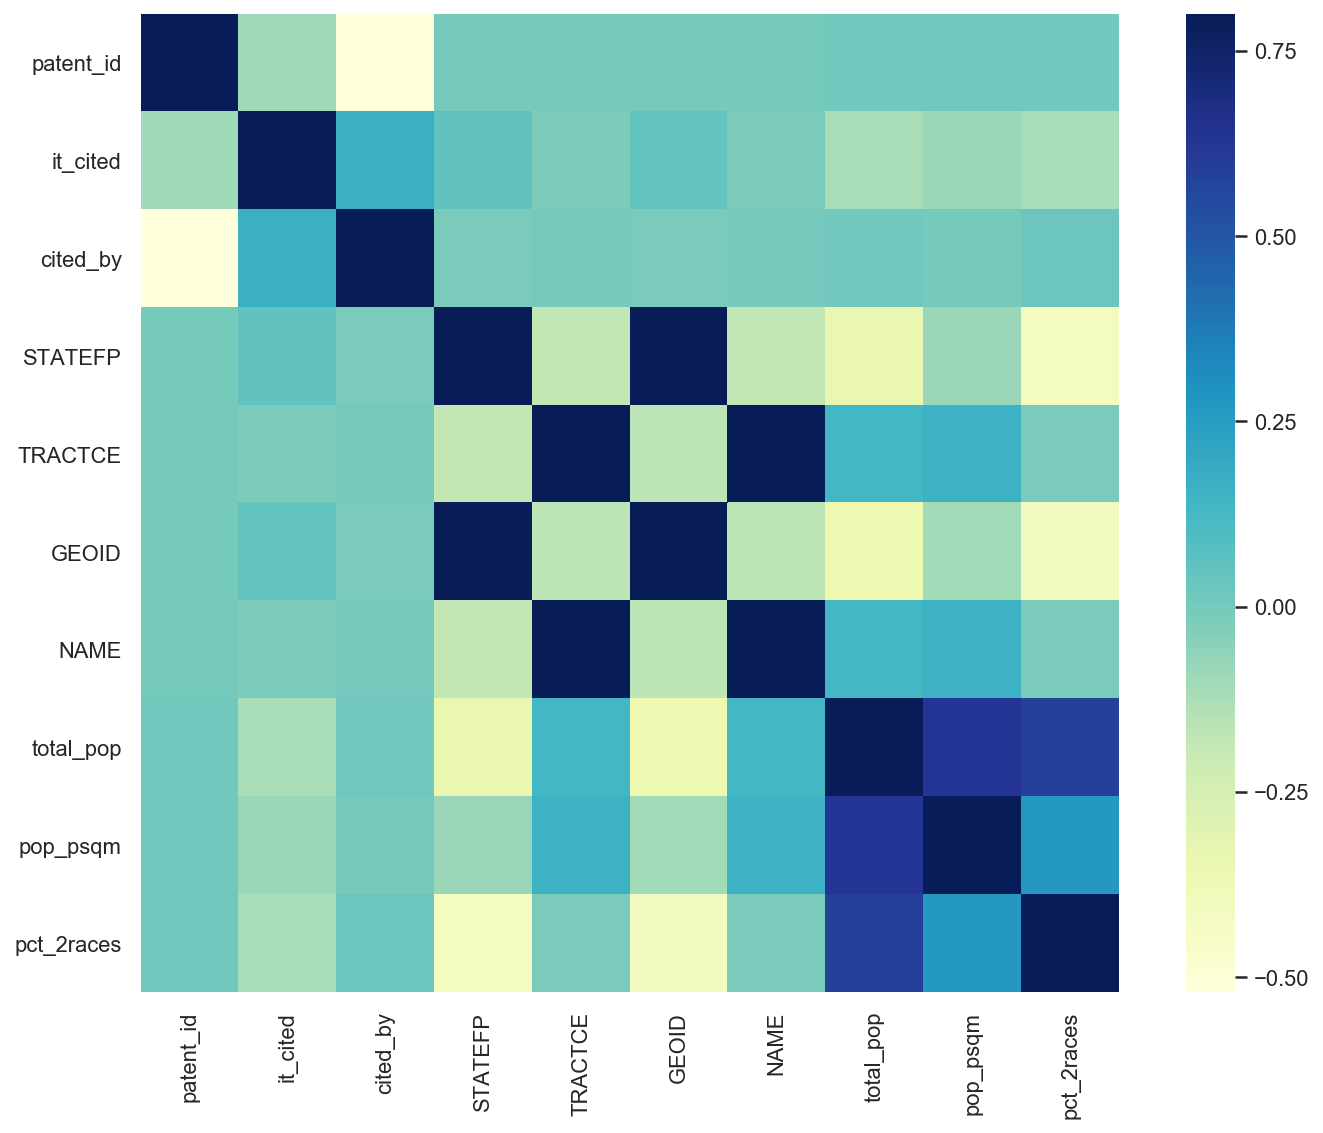

In [10]:
# Correlation Matrix Heatmap
corrmat = merge_census_patent.corr(method ='spearman')
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True,cmap="YlGnBu");

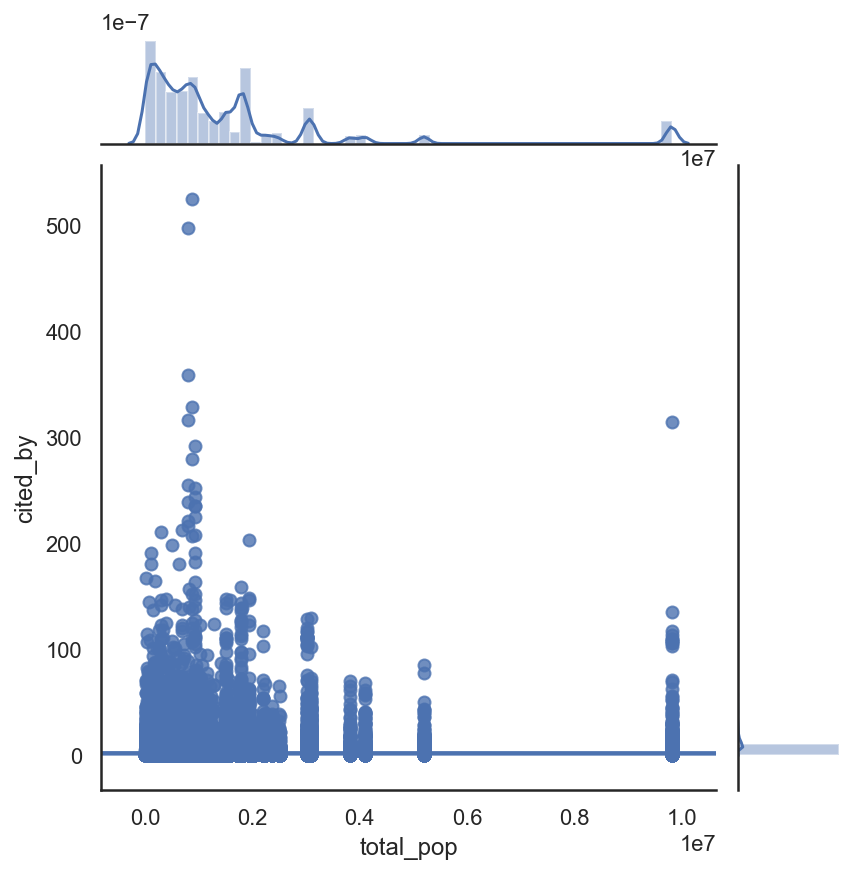

In [11]:
sns.jointplot(x=merge_census_patent['total_pop'], y=merge_census_patent['cited_by'], kind='reg')

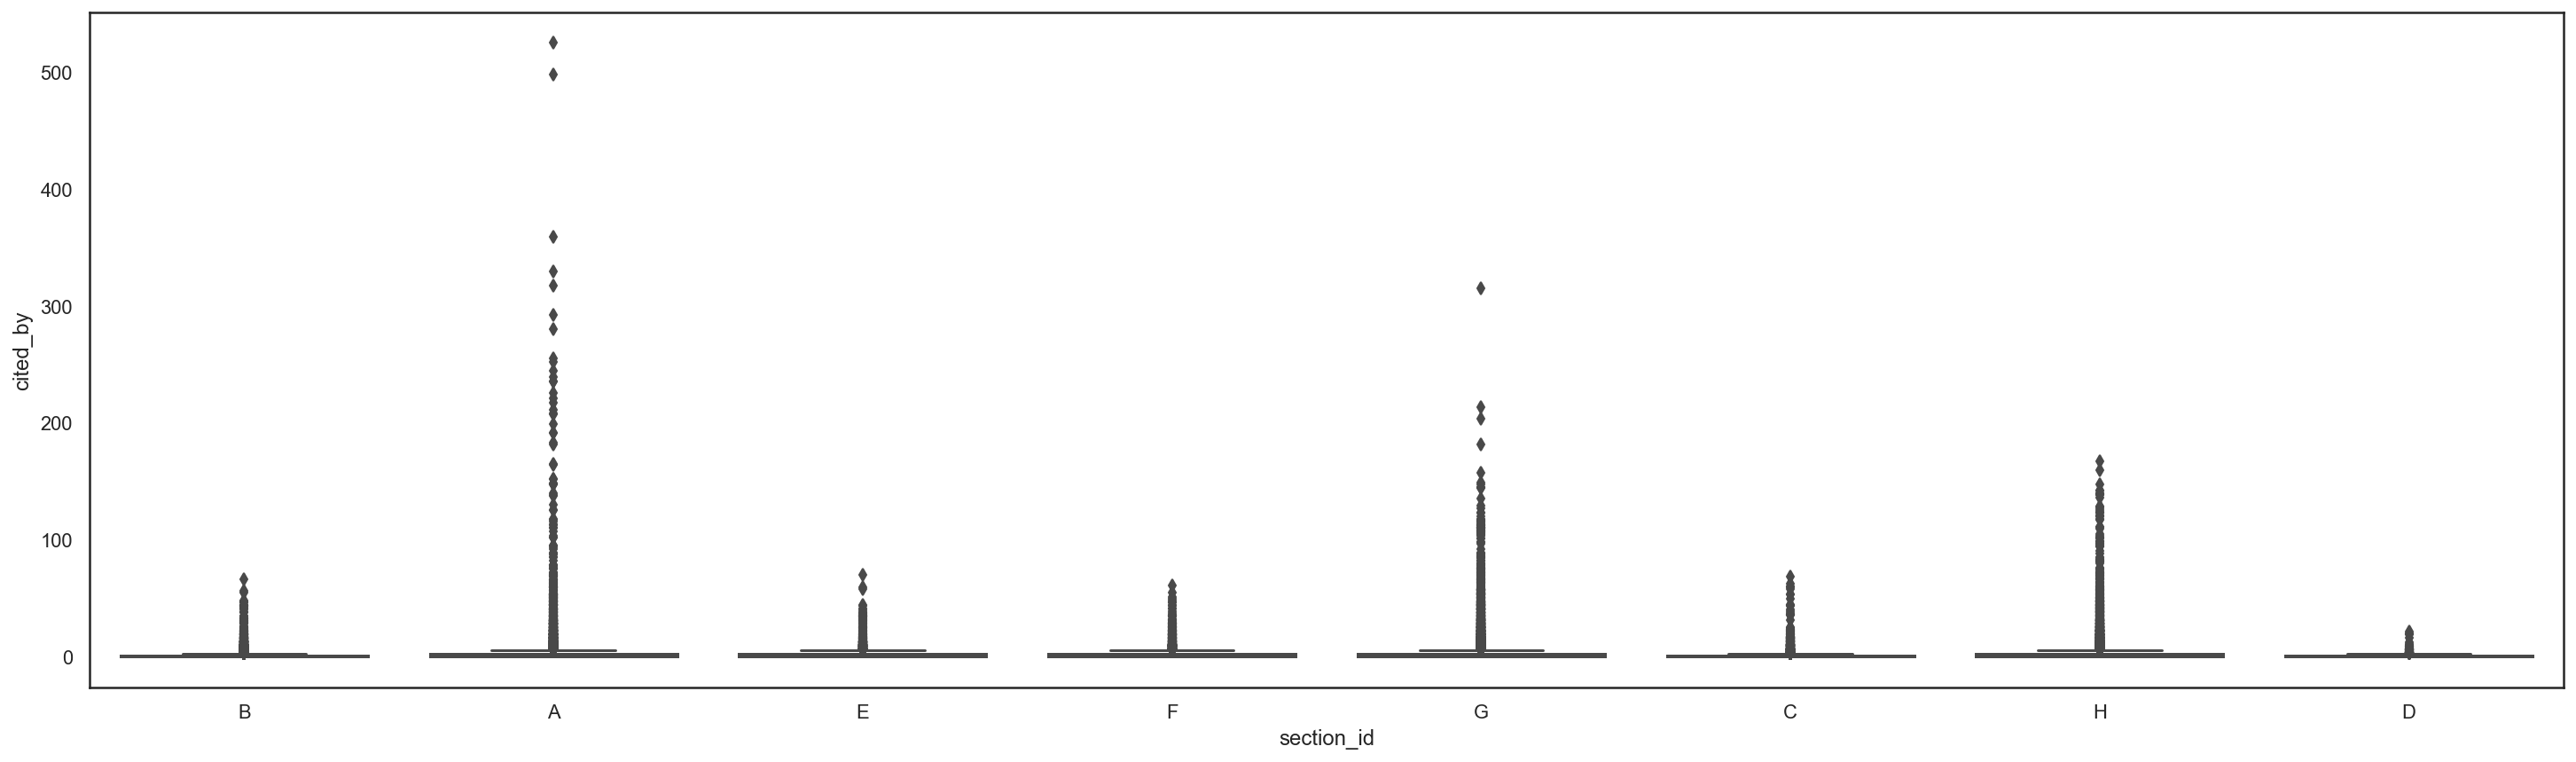

In [12]:
var = 'section_id'
data = pd.concat([merge_census_patent['cited_by'], merge_census_patent[var]], axis=1)
f, ax = plt.subplots(figsize=(25, 7))
fig = sns.boxplot(x=var, y="cited_by", data=data)
#fig.axis(ymin=0, ymax=20);


## Aggregating by county

We now aggregate by county, as we are groupipng diffrently, may be useful to redo the initial visualisations from tract level

In [13]:
tract_count = df_patents.groupby('STCOU').agg({'patent_id':'count', 'cited_by': 'sum'}).reset_index().rename(columns={'patent_id':'patent_output','cited_by':'total_cited_by'}).sort_values(by=['patent_output'],ascending=False)

tract_count['avg_cit_pp'] = (tract_count['total_cited_by']/tract_count['patent_output'])

tract_count_census = pd.merge(tract_count, census_pop, how='left', left_on = 'STCOU', right_on = 'STCOU')
tract_count_census.rename(columns={'POP010210D': 'total_pop', 'POP060210D': 'pop_psqm', 'POP395210D':'pct_2races'}, inplace=True)

tract_count_census.shape
tract_count_census.head()


,STCOU,patent_output,total_cited_by,avg_cit_pp,Area_name,total_pop,pop_psqm,pct_2races
0,06085,13755,28775,2.091967,"Santa Clara, CA",1781642.0,1381.0,4.9
1,06037,5907,10176,1.722702,"Los Angeles, CA",9818605.0,2419.6,4.5
2,06073,5445,9663,1.774656,"San Diego, CA",3095313.0,735.8,5.1
3,53033,4325,9820,2.270520,"King, WA",1931249.0,912.9,5.0
4,06059,4007,9045,2.257300,"Orange, CA",3010232.0,3807.7,4.2


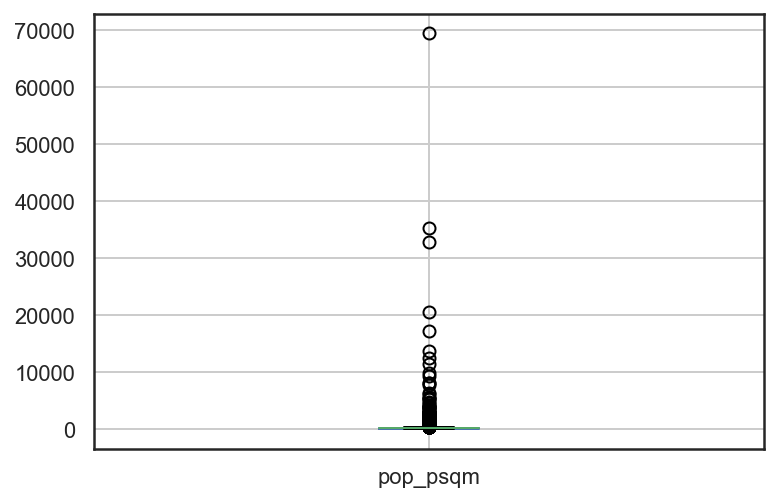

In [14]:
tract_count_census.boxplot(column=["pop_psqm"])

In [15]:
tract_count_census.to_csv ('agg_census.csv', header=True)

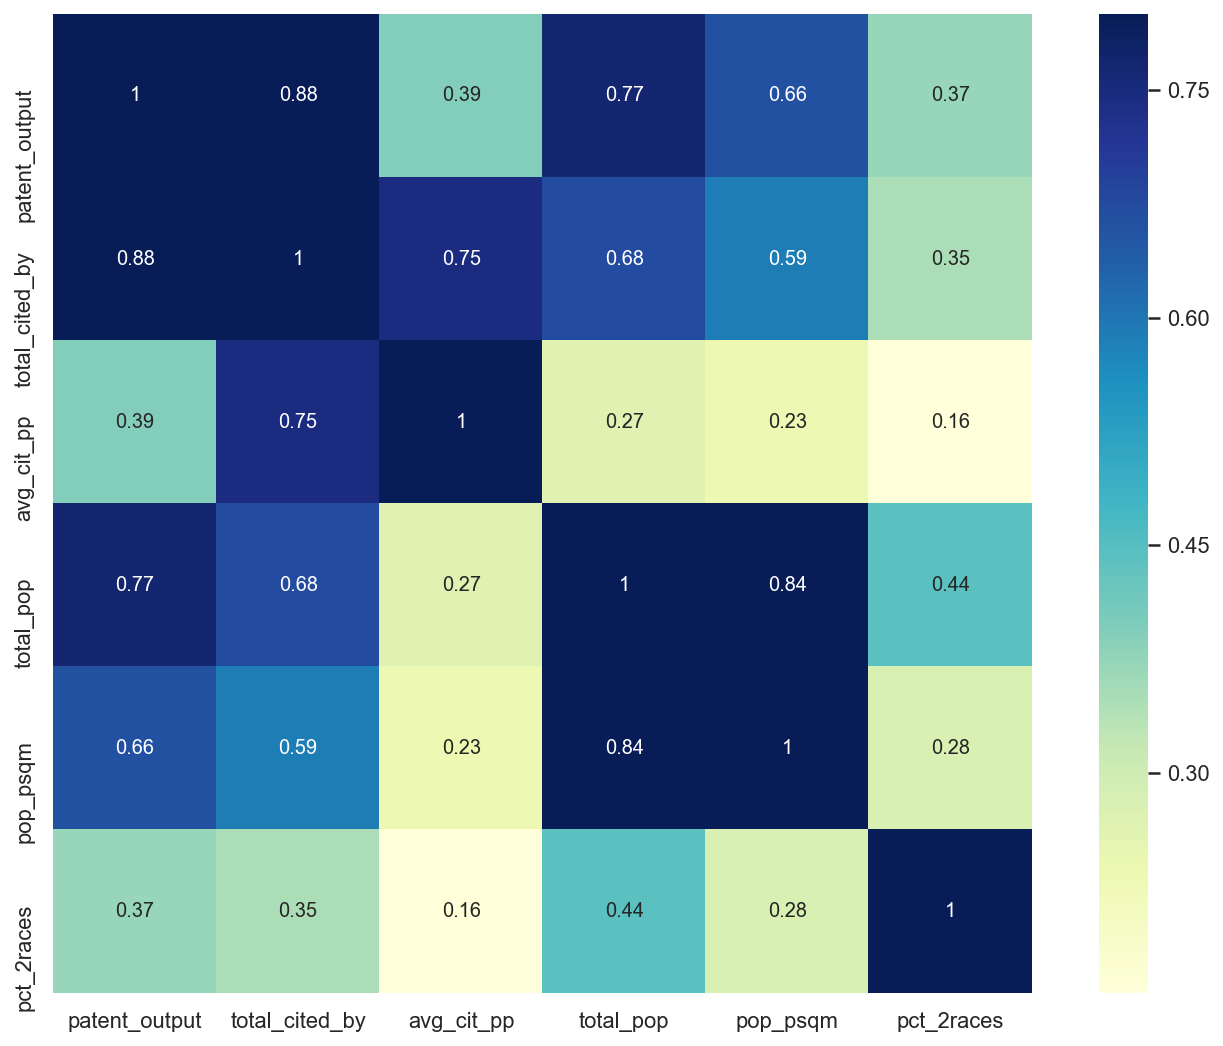

In [16]:
# Correlation Matrix Heatmap
corrmat = tract_count_census.corr(method ='spearman')
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, cbar=True, annot=True, square=True,cmap="YlGnBu");


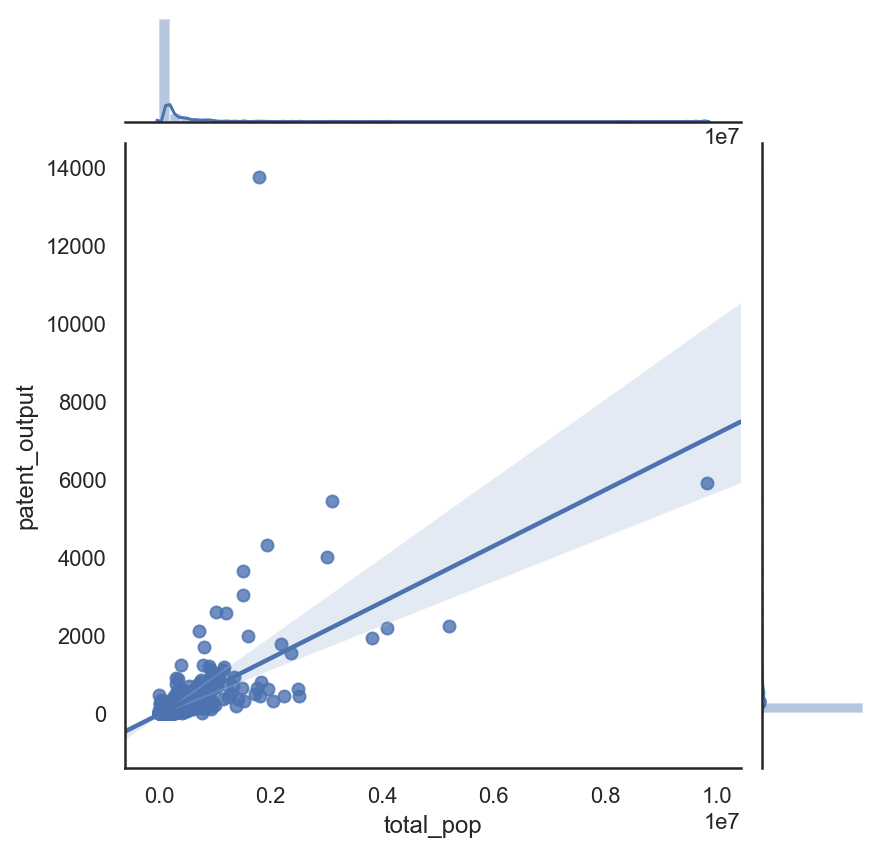

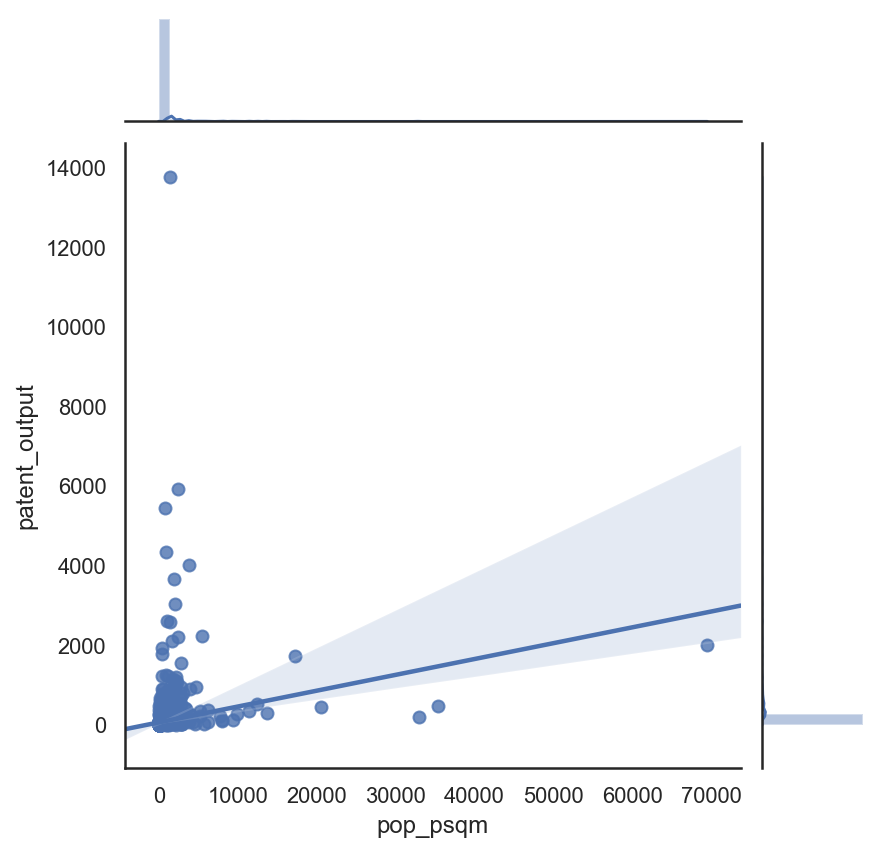

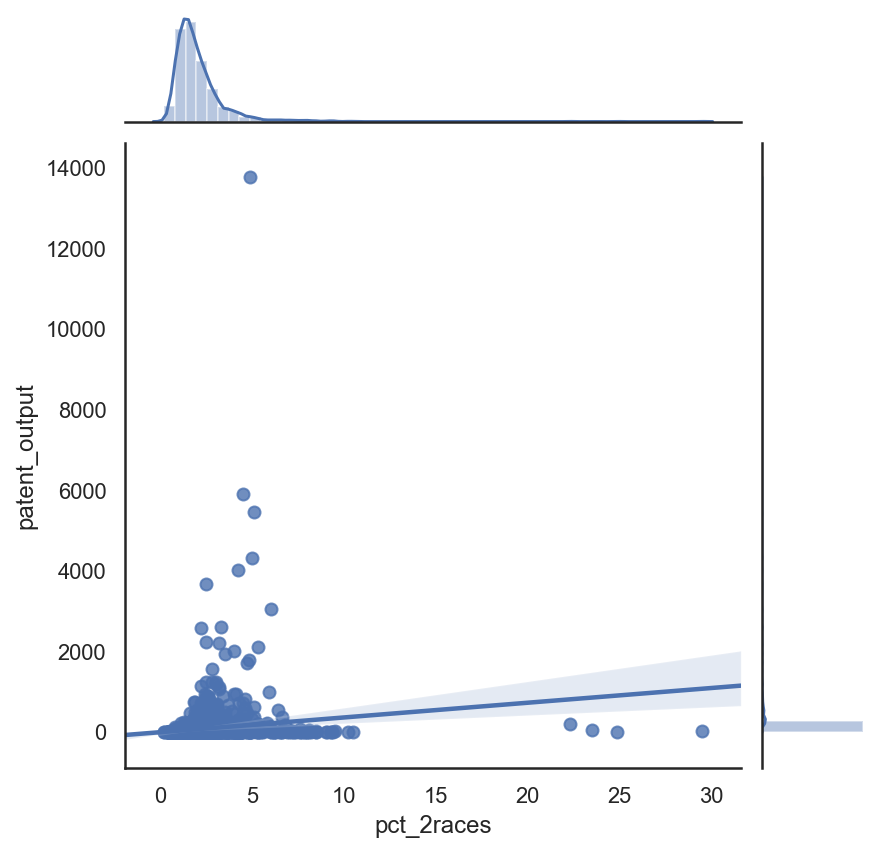

In [17]:
#Correlation plots pop vs. total citations
sns.jointplot(x=tract_count_census['total_pop'], y=tract_count_census['patent_output'], kind='reg', dropna=True)
sns.jointplot(x=tract_count_census['pop_psqm'], y=tract_count_census['patent_output'], kind='reg')
sns.jointplot(x=tract_count_census['pct_2races'], y=tract_count_census['patent_output'], kind='reg')

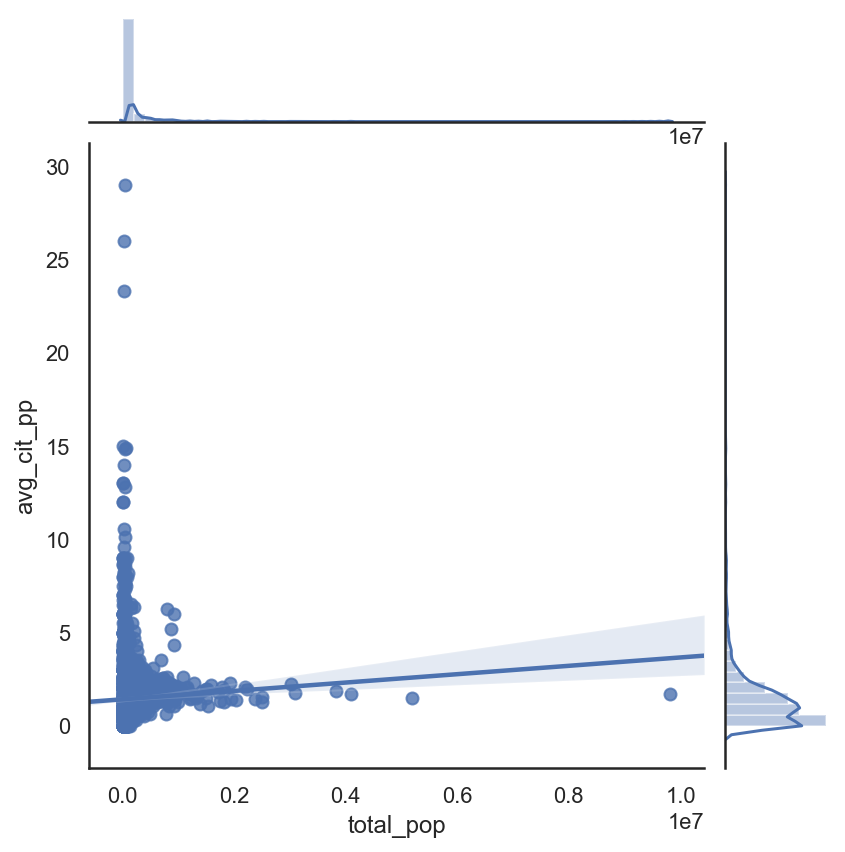

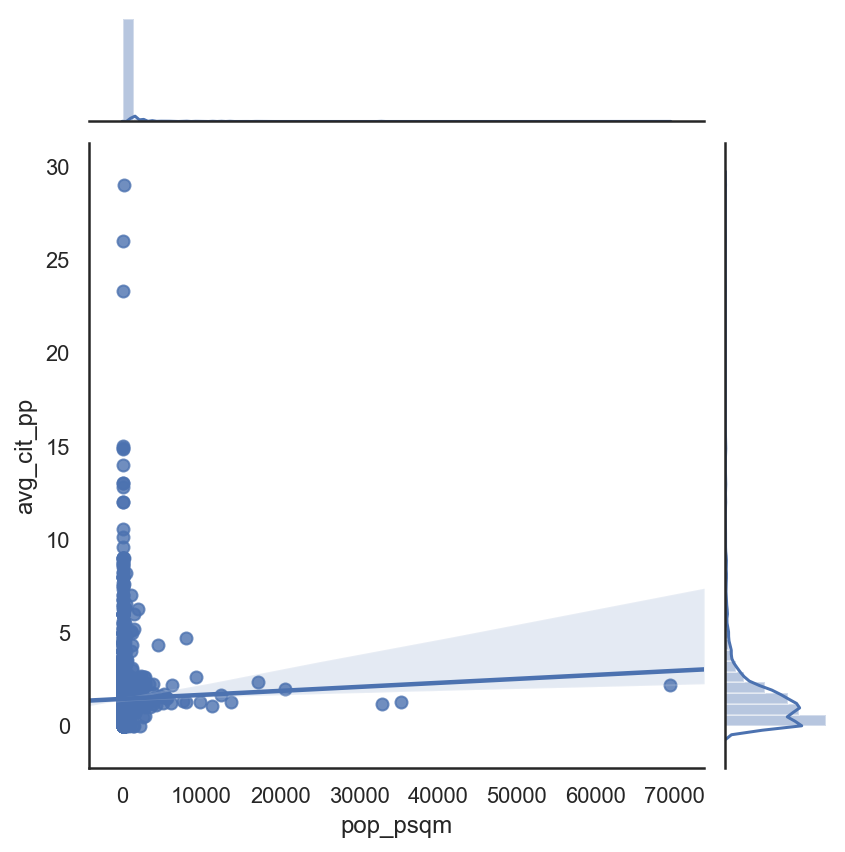

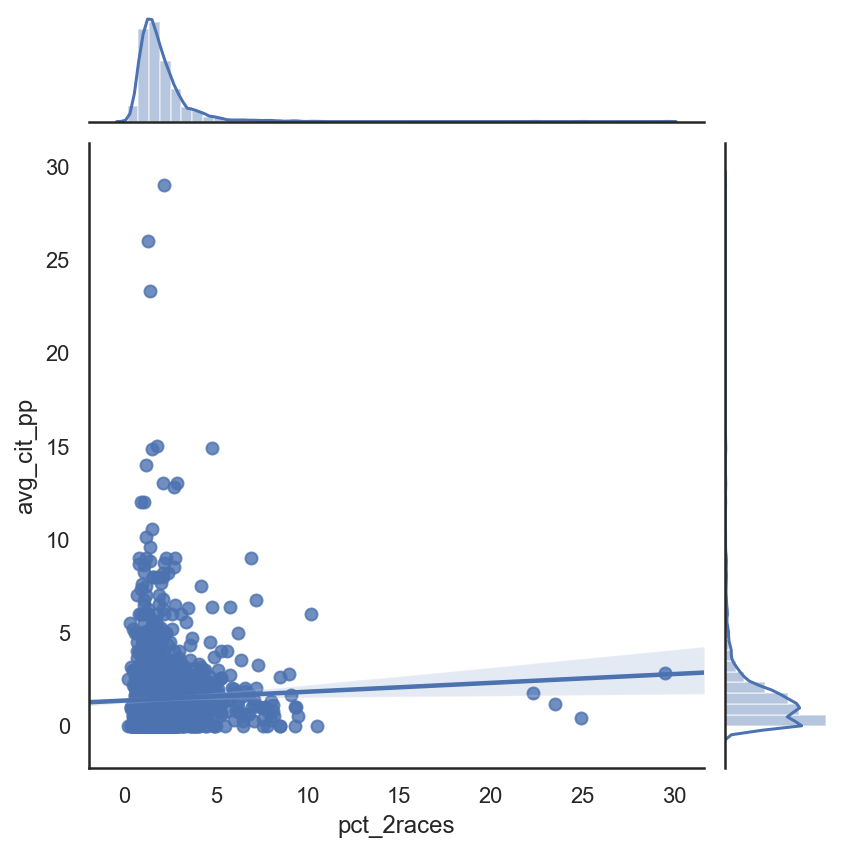

In [18]:
#Correlation plots pop vs. ag citations
sns.jointplot(x=tract_count_census['total_pop'], y=tract_count_census['avg_cit_pp'], kind='reg')
sns.jointplot(x=tract_count_census['pop_psqm'], y=tract_count_census['avg_cit_pp'], kind='reg')
sns.jointplot(x=tract_count_census['pct_2races'], y=tract_count_census['avg_cit_pp'], kind='reg')